<a href="https://colab.research.google.com/github/rasim321/Book_Recommender/blob/main/Book_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Book Recommender using Clustering Techniques:**

Part 1: Using pre-made Goodreads dataset to recommend books


*Adapted from Aatush Mishra [https://www.kaggle.com/aayushmishra1512]*


---



In [89]:
#Adapted from Aayush Mishra [https://www.kaggle.com/aayushmishra1512]

#Part1:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Part 2:
import argparse
from datetime import datetime
import json
import os
import re
import time
from urllib.request import urlopen
from urllib.error import HTTPError
import bs4
from googlesearch import search 


In [2]:
#Load Dataset
from google.colab import files
uploaded = files.upload()

Saving books.csv to books.csv


In [3]:
df = pd.read_csv("books.csv", error_bad_lines=False)

#Let's see the data
df.head()

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


Variables: 

**bookID** - Contains the unique ID for each book/series

**title** - contains the titles of the books

**authors** - contains the author of the particular book

**average_rating**- the average rating of the books, as decided by the users

**ISBN** - Another unique number to identify the book, the International Standard Book Number.

**ISBN 13** - A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.

**language_code** - Helps understand what is the primary language of the book. For instance, eng is standard for English.

**num_pages** - Number of pages the book contains.

**ratings_count** - Total number of ratings the book received.

**text_reviews_count** - Total number of written text reviews the book received.




In [5]:
#How many unique titles
books_n = len(df["title"].unique())
print(f'There are {books_n} unique books in the dataset')

#And unique authors?
author_n = len(df["authors"].unique())
print(f'And there are {author_n} unique authors')

pro_auth_one = df.authors.mode()[0]
pro_auth_two = df.authors.mode()[1]

print(f'The two most prolific authors are {pro_auth_one} and {pro_auth_two} who\
 each penned 40 books.')


There are 10348 unique books in the dataset
And there are 6639 unique authors
The two most prolific authors are P.G. Wodehouse and Stephen King who each penned 40 books.


In [6]:
#Let's find the top 20 books by ratings
from tabulate import tabulate

#Sorting books by those rated over 100k times
df_high_rate = df.loc[df["ratings_count"] > 100000]

#Collecting the top 20 books
top20 = df_high_rate.sort_values(by="average_rating", ascending = False).head(20)

print(tabulate(top20[["title","authors","average_rating"]], headers=['title','author','rating']))

       title                                                                                   author                                                               rating
-----  --------------------------------------------------------------------------------------  -----------------------------------------------------------------  --------
   21  J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings                   J.R.R. Tolkien                                                         4.59
    0  Harry Potter and the Half-Blood Prince (Harry Potter  #6)                               J.K. Rowling/Mary GrandPré                                             4.57
    3  Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)                             J.K. Rowling/Mary GrandPré                                             4.56
 4244  The Complete Maus                                                                       Art Spiegelman                                    

Unsurprisingly, the Lord of the Rings and Harry Potter novels rank numerous times on the list. More surprising is the popularity of manga and graphic novels such as Fullmetal Alchemist, Death Note, and Maus. Another important finding here is that the highest rating among these books is a 4.6. If we look at this ratings blindly, 4.6 may seem like a low to mediocre rating for a book. However, the range of Goodreads ratings are important to consider.  

In [7]:
#Let's see the same list but by number of ratings:

top20_r = df.sort_values(by="ratings_count", ascending = False).head(20)

print(tabulate(top20_r[["title","authors","ratings_count"]]))


-----  ------------------------------------------------------------  --------------------------------------------------  -------
10336  Twilight (Twilight  #1)                                       Stephenie Meyer                                     4597666
 1697  The Hobbit  or There and Back Again                           J.R.R. Tolkien                                      2530894
 1462  The Catcher in the Rye                                        J.D. Salinger                                       2457092
  307  Angels & Demons (Robert Langdon  #1)                          Dan Brown                                           2418736
    3  Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)   J.K. Rowling/Mary GrandPré                          2339585
 4415  Harry Potter and the Chamber of Secrets (Harry Potter  #2)    J.K. Rowling/Mary GrandPré                          2293963
    1  Harry Potter and the Order of the Phoenix (Harry Potter  #5)  J.K. Rowling/Mary GrandPré  

For the number of ratings, Twilight far exceeds other books. This may not be all positive reviews, but the vampire novel did attract a lot of opinions.  

Text(0, 0.5, 'Titles')

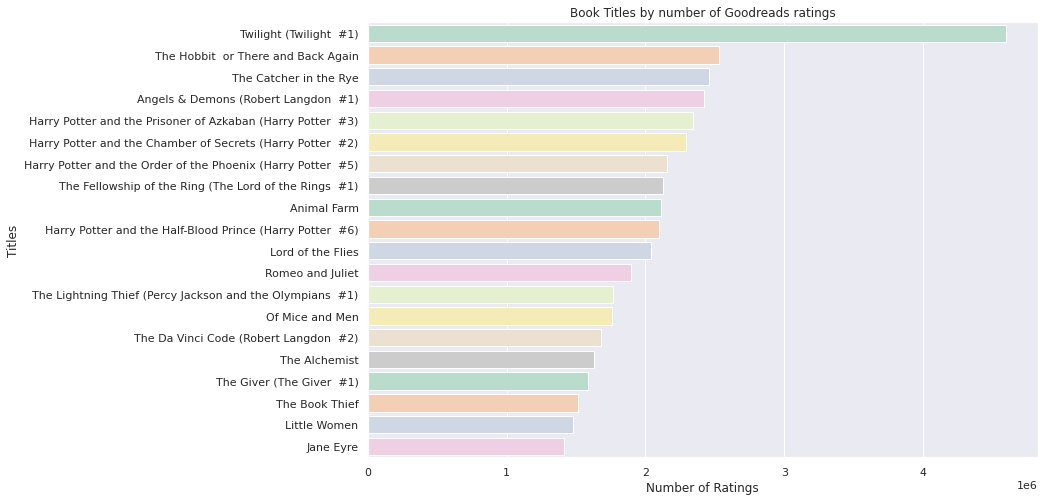

In [8]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x="ratings_count", y="title", data=top20_r, palette='Pastel2').set_title('Book Titles by number of Goodreads ratings')
plt.xlabel("Number of Ratings")
plt.ylabel("Titles")

In [10]:
#Seperate the english books from the dataset

eng = df[df["language_code"]=="eng"]
eng.shape

(8908, 12)

The English language only dataset has 8908 books. 

In [12]:
#Let's make our book recommender

#First we create dummy variables for the ratings
eng.loc[ (eng['average_rating'] >= 0) & (eng['average_rating'] <= 1), 'rating_between'] = "between 0 and 1"
eng.loc[ (eng['average_rating'] > 1) & (eng['average_rating'] <= 2), 'rating_between'] = "between 1 and 2"
eng.loc[ (eng['average_rating'] > 2) & (eng['average_rating'] <= 3), 'rating_between'] = "between 2 and 3"
eng.loc[ (eng['average_rating'] > 3) & (eng['average_rating'] <= 4), 'rating_between'] = "between 3 and 4"
eng.loc[ (eng['average_rating'] > 4) & (eng['average_rating'] <= 5), 'rating_between'] = "between 4 and 5"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [18]:
#Let's get the features for the KNN model
ratings = pd.get_dummies(eng["rating_between"])
features = pd.concat([ratings, eng['average_rating'], eng['ratings_count']], axis=1)
features.head()

#Processing
scaler = MinMaxScaler()
features = scaler.fit_transform(features)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 9.14000000e-01, 4.55816060e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.98000000e-01, 4.68317403e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.84000000e-01, 1.37743803e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.16000000e-01, 1.70303802e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.92000000e-01, 1.78351363e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.44000000e-01, 1.67258779e-04]])

In [20]:
#Fit the knn model
knn_model = neighbors.NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
knn_model.fit(features)
dist, idlist = knn_model.kneighbors(features)

In [24]:
#And create the book recommendation function
def BookRecommender(book_name):
    book_list = []
    book_id = eng[eng['title'] == book_name].index[0]
    for newid in idlist[book_id]:
        book_list.append(eng.loc[newid].title)
    return book_list

In [25]:
#Let's try it out
BookRecommender("Animal Farm")

['Animal Farm',
 'The Return of Lum  Volume 1: Urusei Yatsura (Urusei Yatsura  #2)',
 'Glass House']

Can we improve this Recommender? 

To do so, we would need more data from Goodreads. We may also want to update the dataset with the number of reviews, ratings, and plot summaries. 

**Part 2: Web-Scraping GoodReads**



---

---





In [90]:
def Rater(ratings):

  #Lists for Average Rating and Number of Reviews
  rating_avg= []
  rating_num = []

  for i in ratings: 
    rating_avg.append(re.findall("\d+\.\d+", i)[0])
    try: 
      rating_num.append(re.findall("(?<=—)(.*)(?=ratings)",i)[0])
    except IndexError:
      rating_num.append('0')

  rating_avg = [float(i) for i in rating_avg]
  rating_num = [int(j.replace(",", "").strip()) for j in rating_num]

  return rating_avg, rating_num


def GetDetails(links):

  url = 'https://www.goodreads.com/'
  plot_df = []
  book_all_tags = []
  n_reviews = []
  count = 0

  for link in links:

    book_page = urlopen(url + link)
    soup = bs4.BeautifulSoup(book_page, "html.parser")
    count += 1

    plots = soup.select('#description span')
    if len(plots) > 1:
      summary = []

      for plot in plots:
        summary.append(plot.text)
      
      plot_df.append(summary[1])
        
    else:
      for plot in plots:
        plot_df.append(plot.text)



    #Get book tags
    book_tags = []

    tags = soup.select('.bookPageGenreLink')
    for tag in tags:
      book_tags.append(tag.text)

    book_tags = [x for x in book_tags if not any(c.isdigit() for c in x)]
    book_all_tags.append(book_tags)
    time.sleep(1)
    print("Book: " + str(count) +  " out of " + str(len(links)))


    #Get Number of Reviews:
    reviews = soup.select('.reviewControls--left.greyText')
    rev = []
    for review in reviews:
      rev.append(review.text)
    rev = re.findall("\s\d+\s|\d+,\d+", rev[0])
    rev = [item.replace(",", "") for item in rev]
    n_reviews.append(int(rev[1]))
    
  return plot_df, book_all_tags, n_reviews

def ListScraper(link):
  url = 'https://www.goodreads.com/'

  #Check if the link contains a Goodreads list
  if "list" in link:
    pass
  else:
    print("This link does not contain a GoodReads list")

  #Strip the list url from the full url
  if link.startswith(url):
    list_url = link.replace(url, '')
  else:
    list_url = link

  #Make lists for the data we want
  titles = []
  authors = []
  ratings = []
  book_links = []

  #Loop through the number of pages
  while list_url != None:

    #Set up the URL
    source = urlopen(url + list_url)
    soup = bs4.BeautifulSoup(source, "html.parser")

    #Get all titles from this page
    books = soup.select(".bookTitle span")
    for book in books:
      titles.append(book.text)
    
    #Get the authors
    writers = soup.select(".authorName span")
    for author in writers:
      authors.append(author.text)

    #Get the ratings:
    rates = soup.select(".minirating")
    for rate in rates:
      ratings.append(rate.text)

    #Get the links:
    links = soup.findAll('a', {'class': 'bookTitle'})
    for link in links:
      book_links.append(link['href'])

    #Check if there is a next page and either end the program or continue to next page
    if not soup.select(".pagination"):
      list_url = None
    else:
      next = soup.select(".pagination")[0].select(".next_page")[0].get('href')
      if next != None:
        list_url = next
        print("Going to next page...")
      else:
        list_url = next
        print("No more pages to scan.")
  
  #Transform string ratings to average and number of ratings
  rating_avg, rating_num = Rater(ratings)

  #Get book details: plot summary, tags, and number of reviews
  plot_df, book_all_tags, num_reviews = GetDetails(book_links)
  
  book_df = pd.DataFrame({
      'title': titles,
      'author': authors,
      "avg_rate": rating_avg,
      "number of ratings": rating_num,
      "link": book_links,
      "plot summary": plot_df,
      "tags": book_all_tags,
      "reviews": num_reviews
  })
  
  return book_df
  


In [3]:
manga = ListScraper("https://www.goodreads.com/?ref=nav_home")
manga.head(10)



This link does not contain a GoodReads list


NameError: ignored

In [91]:
#@title Default title text
# book_page = urlopen('https://www.goodreads.com/book/show/6690979-black-butler-vol-1')
# soup = bs4.BeautifulSoup(book_page, "html.parser")

def BookDetails(links, title_data=False, author_data=False, ratings_data = False):

  url = 'https://www.goodreads.com/'

  #Additonal Details
  title_df = []
  author_df = []
  avg_rating_df = []
  ratings_num_df = []

  #Regular details
  plot_df = []
  book_all_tags = []
  n_reviews = []
  count = 0

  for link in links:
  
    #check if link is the full url or just book link
    if "goodreads" in link:
      book_page = urlopen(link)
    else:
      book_page = urlopen(url + link)

    #Create the BS object
    soup = bs4.BeautifulSoup(book_page, "html.parser")
    count += 1

    #Check if title data is required
    if title_data == True:
      title = soup.select('#bookTitle')
      for j in title:
        title_df.append(j.text.strip())
    else:
      pass
    
    #Check if author data is required
    if author_data == True:
      author = soup.find("span", itemprop="name").text
      author_df.append(author)
    else:
      pass
    
    #Check if ratings data is required
    if ratings_data == True:
      rating = soup.find("span", itemprop="ratingValue")
      for l in rating:
        avg_rating_df.append(float(l.strip()))
      
      ratings_num = soup.find("meta", itemprop="ratingCount").get('content')
      ratings_num_df.append(ratings_num)
    else:
      pass


    #Get plot summaries
    plots = soup.select('#description span')
    if len(plots) > 1:
      summary = []

      for plot in plots:
        summary.append(plot.text)
      
      plot_df.append(summary[1])
        
    else:
      for plot in plots:
        plot_df.append(plot.text)



    #Get book tags
    book_tags = []

    tags = soup.select('.bookPageGenreLink')
    for tag in tags:
      book_tags.append(tag.text)

    book_tags = [x for x in book_tags if not any(c.isdigit() for c in x)]
    book_all_tags.append(book_tags)
    time.sleep(1)
    print("Book: " + str(count) +  " out of " + str(len(links)))


    #Get Number of Reviews:
    n_review = soup.find("meta", itemprop="reviewCount").get('content')
    n_reviews.append(n_review)
  
  if title_data==False:
    title_df = [None] * len(links)
  if author_data==False:
    author_df = [None] * len(links)
  if ratings_data==False:
    avg_rating_df = [None] * len(links)
    ratings_num_df = [None] * len(links)
    
  book_df = pd.DataFrame({
      'title': title_df,
      'author': author_df,
      "avg_rate": avg_rating_df,
      "number_of_ratings": ratings_num_df,
      "plot_summary": plot_df,
      "tags": book_all_tags,
      "reviews": n_reviews
  })
  return book_df

# plots, tags, reviews = GetDetails(manga["link"][0:2])
# print(plots, tags, reviews)

In [94]:
try_a = BookDetails(BookLinks(["Debt: the last 5000 years","Holidays on ice","Catcher in the Rye"]), title_data=True,author_data=True, ratings_data=True)
try_a

Book: 1 out of 3
Book: 2 out of 3
Book: 3 out of 3


,title,author,avg_rate,number_of_ratings,plot_summary,tags,reviews
0,"Debt: The First 5,000 Years",David Graeber,4.17,13261,"Before there was money, there was debt Every e...","[Economics, History, Nonfiction, Anthropology,...",1729
1,Holidays on Ice,David Sedaris,3.90,114559,David Sedaris's beloved holiday collection is ...,"[Humor, Nonfiction, Short Stories, Autobiograp...",5921
2,The Catcher in the Rye,J.D. Salinger,3.81,2840676,The hero-narrator of The Catcher in the Rye is...,"[Classics, Fiction, Young Adult, Literature, A...",59761


Before there was money, there was debt Every economics textbook says the same thing: Money was invented to replace onerous and complicated barter systems—to relieve ancient people from having to haul their goods to market. The problem with this version of history? There’s not a shred of evidence to support it.Here anthropologist David Graeber presents a stunning reversal of conventional wisdom. He shows that for more than 5,000 years, since the beginnings of the first agrarian empires, humans have used elaborate credit systems to buy and sell goods—that is, long before the invention of coins or cash. It is in this era, Graeber argues, that we also first encounter a society divided into debtors and creditors.  Graeber shows that arguments about debt and debt forgiveness have been at the center of political debates from Italy to China, as well as sparking innumerable insurrections. He also brilliantly demonstrates that the language of the ancient works of law and religion (words like “gu

In [66]:
title = soup.select('#bookTitle')

author_df = []
author = soup.find("span", itemprop="name").text
print(author)

George Orwell


In [92]:
book_page = urlopen('https://www.goodreads.com/book/show/170448.Animal_Farm')
soup = bs4.BeautifulSoup(book_page, "html.parser")

title_df = []

title = soup.find("span", itemprop="name").text
print(title)

# reviews = soup.select('.reviewControls--left.greyText')
# print(reviews)
# rev = []
# for review in reviews:
#   rev.append(review.text)
# print(rev)
# #\b\d+,\d+|\d+\b
# rev = re.findall("\s\d+\s|\d+,\d+", rev[0])
# rev = [item.replace(",", "") for item in rev]
# int(rev[1])




KeyboardInterrupt: ignored

In [93]:
#How to get book page details from book titles: 

#Take a list of Book titles and returns an array of links
def BookLinks(query):

  #Empty list to store links
  links = []

  #Search each search query
  for q in query:
    # print(q)

    #Specify search feature in goodreads.com
    url = ' site: goodreads.com'

    #Add the search query to the search term
    search_q = str(q) + url

    #Get the goodreads link 
    gdrd_l = search(search_q, tld="com", num=1, stop=1, pause=2)

    #Append to list
    for i in gdrd_l:
      links.append(i)
  
  #Return the list
  return links


books_two = BookLinks(["Harry Potter and the Half Blood Prince","Animal Farm","Freakonomics"])
  

In [7]:
books_two

['https://www.goodreads.com/book/show/1.Harry_Potter_and_the_Half_Blood_Prince',
 'https://www.goodreads.com/book/show/170448.Animal_Farm',
 'https://www.goodreads.com/book/show/1202.Freakonomics']